In [1]:
from scipy import misc, sparse
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from skimage import io
import warnings
import json
warnings.filterwarnings('ignore')
from shapely.geometry.polygon import LinearRing, Polygon
from shapely.geometry.point import Point
import pickle
from itertools import compress
from ast import literal_eval

from IPython.display import display, HTML

colorsHex = [
    '#FFFFFF',
    '#E4E4E4',
    '#888888',
    '#222222',
    '#FFA7D1',
    '#E50000',
    '#E59500',
    '#A06A42',
    '#E5D900',
    '#94E044',
    '#02BE01',
    '#00E5F0',
    '#0083C7',
    '#0000EA',
    '#E04AFF',
    '#820080'
]


def HexToRGB(hexStr):
    return tuple(int(hexStr.strip('#')[i:i+2], 16) for i in (0, 2 ,4))

def RGBToHex(value):
    return ('#%02x%02x%02x' % (value[0], value[1], value[2])).upper()

def idxToHex(idx):
    return colorsHex[idx]

def idxToRGB(idx):
    return HexToRGB(colorsHex[idx])

def HexToIdx(hexStr):
    return colorsHex.index(hexStr)

def RGBToIdx(rgb):
    return HexToIdx(RGBToHex(rgb))

def showImage(image, size=(12,12), ax=None):
    if not ax:
        _, ax = plt.subplots(1,1, figsize=size)
    ax.imshow(image.transpose((1,0,2)), interpolation='nearest')
    ax.grid(False)
    
def canvas_idx_to_rgb(canvas):
    canvas_final = np.ones((canvas.shape[0],canvas.shape[1], 3), dtype=np.int64)*255
    for x in range(canvas.shape[0]):
        for y in range(canvas.shape[1]):
            canvas_final[x,y] = idxToRGB(canvas[x,y])
    return canvas_final



Threshold can again be changed, I chose to keep everything, just to see

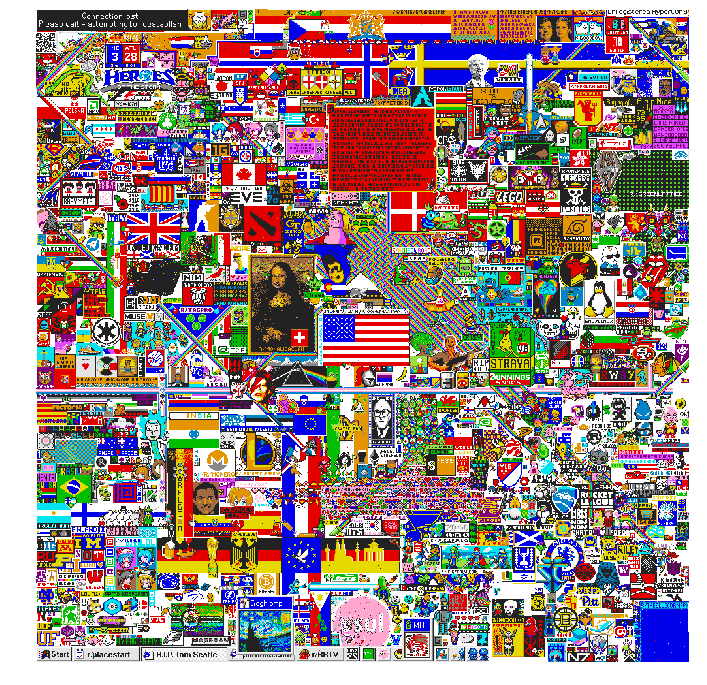

In [2]:
area_threshold = 1

dataset = pd.read_csv("dataset/tile_placements.csv")


dataset = dataset[(dataset['x_coordinate'] < 1000) & (dataset['y_coordinate'] < 1000)]

dataset['coordinates_packed'] = dataset['x_coordinate'] * 1000 + dataset['y_coordinate']

dataset.drop(columns=['x_coordinate', 'y_coordinate'], inplace=True)
# dataset['coordinates'] = list(zip(dataset['x_coordinate'], dataset['y_coordinate']))

canvas_corr = np.load('canvas_corr_idx.npy')
canvas_final = np.load('canvas_final_idx.npy')

with open('atlas/atlas_with_mask.pickle', 'rb') as infile:
    atlas = pickle.load(infile)

atlas_with_poly = [poly for poly in atlas if 'poly_mask' in poly and len(poly['poly_mask'][0]) > area_threshold]

id2Idx = {shape['id']: idx for idx, shape in enumerate(atlas_with_poly)}
idx2Id = {v: k for k,v in id2Idx.items()}

idx2name = {idx:poly['name'] for idx, poly in enumerate(atlas_with_poly)}
name2idx = {v:k for k,v in idx2name.items()}

polys = [np.array(shape['poly_mask']) for shape in atlas_with_poly]

polys_packed = [poly[0]*1000+poly[1] for poly in polys]

idx2subs = {idx: [x.strip().lstrip('/') for x in atlas_with_poly[idx]['subreddit'].split(',')] for idx in range(len(atlas_with_poly))}

valid_coords = list(set([tup[0]*1000+tup[1] for poly in polys for tup in list(map(tuple, poly.T))]))

dataset =  dataset[dataset['coordinates_packed'].isin(valid_coords)]

dataset['user'] = dataset['user'].astype('category')

starting_ts = int(dataset['ts'].min())
dataset['ts'] = (dataset['ts']-starting_ts)//1000

max_ts = dataset['ts'].max()

dataset.sort_values(by='ts', ascending=False, inplace=True)
# color_correctness = []
# for ts, _, color, coords in dataset.values:
#     x, y = coords//1000, coords%1000
#     color_correctness.append(canvas_corr[x,y] == color)
# color_correctness = np.array(color_correctness)
# dataset['correct'] = color_correctness
dataset['ts_hour'] = dataset['ts']//3600
dataset['ts_minute'] = dataset['ts']//60
final_df = dataset.drop_duplicates(['coordinates_packed'])
canvas_final = np.zeros((1000,1000), dtype=np.int64)
for coordinates_packed, color in final_df.reset_index()[['coordinates_packed', 'color']].values:
    x = coordinates_packed//1000
    y = coordinates_packed%1000
    canvas_final[x,y] = color
showImage(canvas_idx_to_rgb(canvas_final))
plt.axis('off');

Some utilities functions

In [3]:
def resize_array_with_bbox(array, shape_idx):
    min_x, min_y, max_x, max_y = atlas_with_poly[shape_idx]['poly'].bounds
    return array[int(min_x)+1:int(max_x), int(min_y)+1:int(max_y)]

def get_shape_in_time(shape_idx, time=max_ts, dataset=dataset):
    shape_df = dataset[(dataset['ts'] <= time) & dataset.coordinates_packed.isin(polys_packed[shape_idx])].drop_duplicates(['coordinates_packed'])
    canvas = np.zeros((1000,1000), dtype=np.int64)
    for coordinates_packed, color in shape_df.reset_index()[['coordinates_packed', 'color']].values:
        x = coordinates_packed//1000
        y = coordinates_packed%1000
        canvas[x,y] = color
    return canvas

def get_shape_with_previous(shape_idx, prev_canvas, prev_time, time=max_ts, dataset_light=dataset):
    dataset_light = dataset_light[(dataset_light['ts'] >= prev_time)]
    dataset_internal = (dataset_light[(dataset_light['ts'] <= time)]
                        .drop_duplicates(['coordinates_packed']))

    for coordinates_packed, color in dataset_internal.reset_index()[['coordinates_packed', 'color']].values:
        x = coordinates_packed//1000
        y = coordinates_packed%1000
        prev_canvas[x,y] = color

    return prev_canvas, dataset_light

def shape_correctness_in_time(shape_idx, time=max_ts, dataset=dataset):
    shape_at_time = get_shape_in_time(shape_idx, time, dataset).reshape(-1)[polys_packed[shape_idx]]
    shape_corrected = canvas_corr.reshape(-1)[polys_packed[shape_idx]]
    return np.mean(shape_at_time == shape_corrected)

def get_ratio(shape_idx, canvas):
    shape_at_time = canvas.reshape(-1)[polys_packed[shape_idx]]
    shape_corrected = canvas_corr.reshape(-1)[polys_packed[shape_idx]]
    return np.mean(shape_at_time == shape_corrected)

Run the next cell and not the one after.

Contains the ratio of correct pixel for each hour, e.g. `integrity_per_hour[0][2]` is the percentage of completion (compared to the corrected canvas) of the figure at index 0 and after 2 hours.

In [5]:
# Load this and skip next cell
time = np.arange(0, max_ts, 3600)
integrity_per_hour = np.load("integrity_per_hour.npy")

In [6]:
integrity_per_hour = []
for shape_idx in range(len(atlas_with_poly)):
    dataset_light = dataset[dataset.coordinates_packed.isin(polys_packed[shape_idx])]

    time = np.arange(0, max_ts, 3600)
    ratio = np.zeros_like(time, dtype=np.float64)
    for idx, t in enumerate(time):
        ratio[idx] = shape_correctness_in_time(shape_idx, t, dataset=dataset_light)
    integrity_per_hour.append(ratio)
#     if shape_idx%10 == 9:
#         print("%d/%d"%(shape_idx+1,len(atlas_with_poly)))
integrity_per_hour = np.array(integrity_per_hour)

This allows to plot the integrity in function of the time

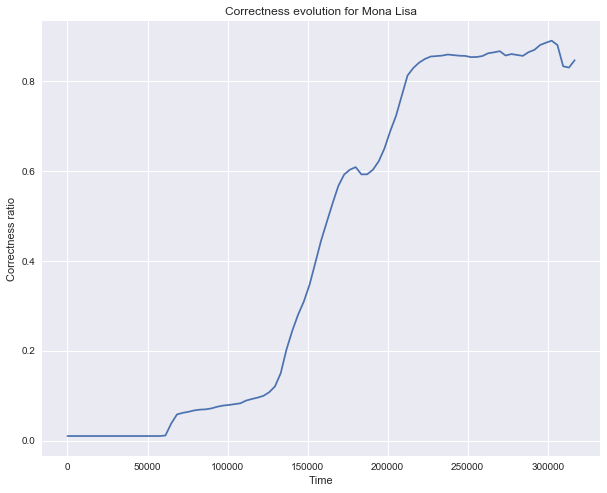

In [14]:
shape_idx = 2

plt.figure(figsize=(10,8))
plt.plot(time, integrity_per_hour[shape_idx])
plt.title("Correctness evolution for " + idx2name[shape_idx])
plt.xlabel("Time")
plt.ylabel("Correctness ratio");

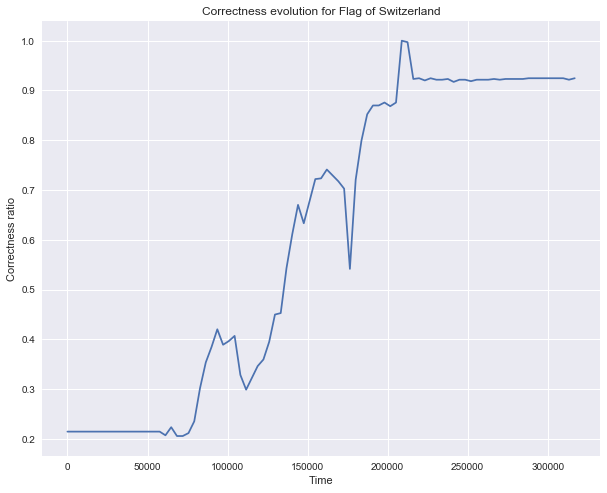

In [15]:
shape_idx = 1

plt.figure(figsize=(10,8))
plt.plot(time, integrity_per_hour[shape_idx])
plt.title("Correctness evolution for " + idx2name[shape_idx])
plt.xlabel("Time")
plt.ylabel("Correctness ratio");

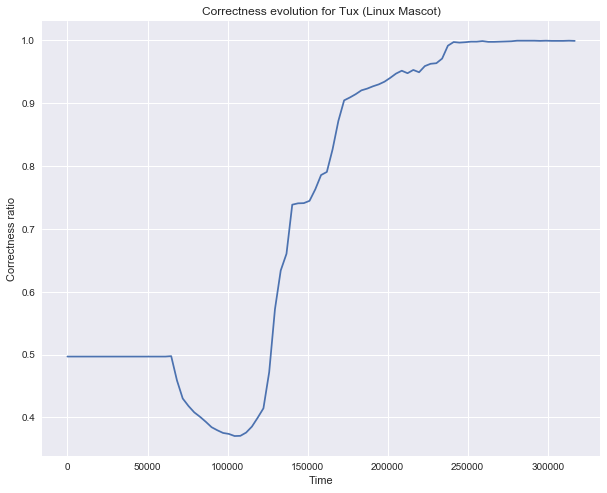

In [48]:
shape_idx = 0

plt.figure(figsize=(10,8))
plt.plot(time, integrity_per_hour[shape_idx])
plt.title("Correctness evolution for " + idx2name[shape_idx])
plt.xlabel("Time")
plt.ylabel("Correctness ratio");

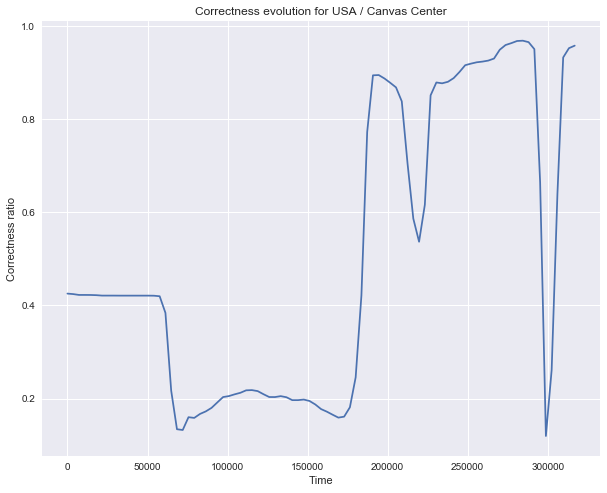

In [49]:
shape_idx = name2idx['USA / Canvas Center']

plt.figure(figsize=(10,8))
plt.plot(time, integrity_per_hour[shape_idx])
plt.title("Correctness evolution for " + idx2name[shape_idx])
plt.xlabel("Time")
plt.ylabel("Correctness ratio");

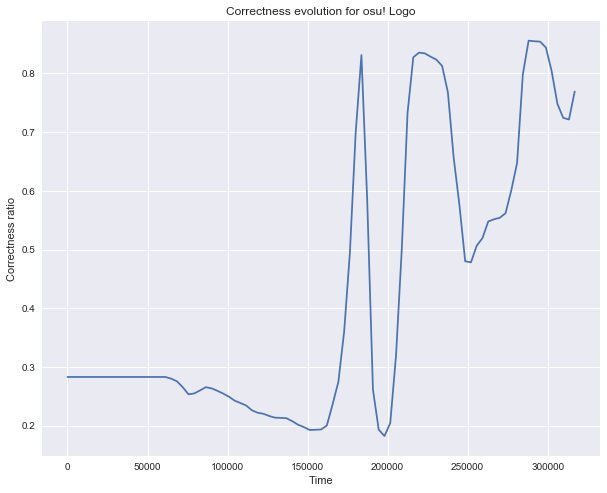

In [50]:
shape_idx = name2idx['osu! Logo']

plt.figure(figsize=(10,8))
plt.plot(time, integrity_per_hour[shape_idx])
plt.title("Correctness evolution for " + idx2name[shape_idx])
plt.xlabel("Time")
plt.ylabel("Correctness ratio");

Let's plot the integrity plot for every shape with a size of > 500

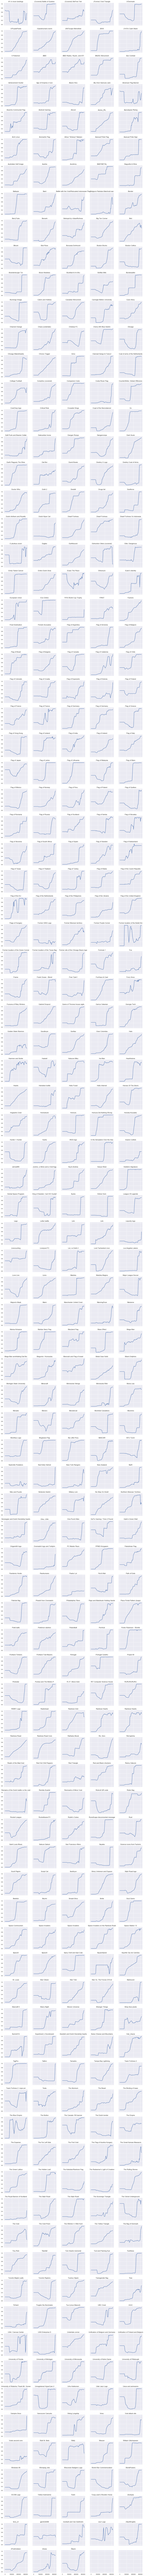

In [520]:
big_shapes = [idx for idx, poly in enumerate(atlas_with_poly) if len(poly['poly_mask'][0]) > 500]
big_shapes = np.array([x[0] for x in sorted(zip(big_shapes, map(idx2name.get, big_shapes)), key=lambda x: x[1])])
selection = integrity_per_hour[big_shapes]

num_cols = 5
num_rows = int(np.ceil(len(selection)/num_cols))
fig_length = int(np.ceil(18/num_cols*num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,fig_length), sharex=True, sharey=True)
for shape_idx in range(len(selection)):
    row = shape_idx//num_cols
    col = shape_idx%num_cols
    ax = axes[row][col]
    ax.plot(time, integrity_per_hour[big_shapes[shape_idx]])
    ax.set_title(idx2name[big_shapes[shape_idx]])
#     ax.set_xlabel("Time")
#     ax.set_ylabel("Correctness ratio");
# plt.tight_layout()

We try to detect the falls in integrity to detect the attacks, no falls = no attack. This works with a threshold value.

The function returns the time where the attack started and the time of the "alarm" which correspond to one of the lowest point of the attack (the one reaching threshold), this could be used to see the success of the attack.

The threshold can be interpreted as both the sucess and the strength of the attack.

<Figure size 432x288 with 0 Axes>

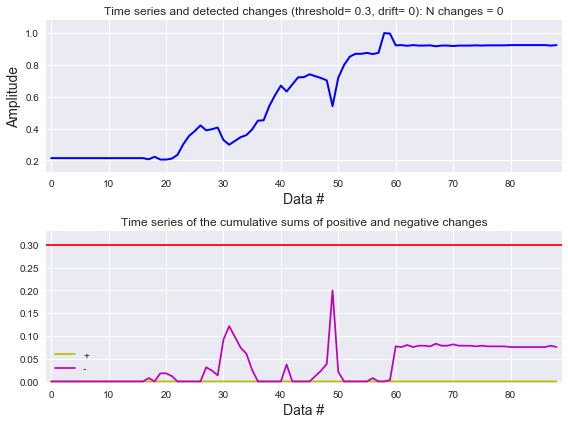

<Figure size 432x288 with 0 Axes>

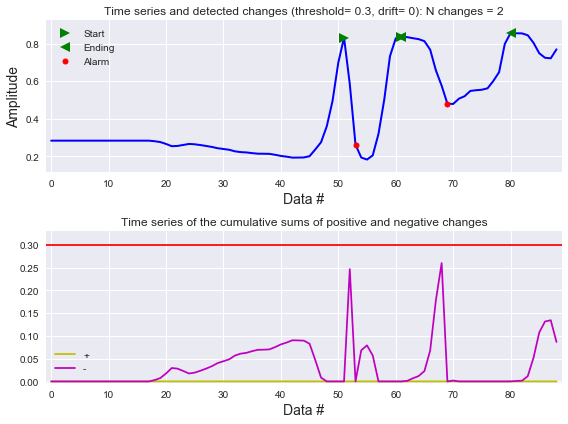

In [406]:
from detect_cusum import *

def get_negative_drops(shape_idx, threshold=0.3, integrity_per_hour=integrity_per_hour):
    t_alarm, t_start, t_end, _ = detect_cusum(integrity_per_hour[shape_idx], threshold=threshold, ending=True, show=False)
    return t_start, t_alarm

plt.figure(0)
detect_cusum(integrity_per_hour[1], threshold=0.3, ending=True)
plt.figure(1);
detect_cusum(integrity_per_hour[name2idx['osu! Logo']], threshold=0.3, ending=True);

We know compute the number of fall for each subreddit for different thresholds.

The values are then the number of attacks with a strength >= threshold.

In [531]:
shapes_selection = [idx for idx, poly in enumerate(atlas_with_poly) if len(poly['poly_mask'][0]) > 500]

time = np.arange(0, max_ts, 3600)
thresholds = np.linspace(0.2, 0.8, 10)[::-1]
shape_falls = []
for shape_idx in shapes_selection:
    shape_falls.append([])
    shape_falls[-1].append(idx2subs[shape_idx])
    for threshold in thresholds:
        num_falls = len(get_negative_drops(shape_idx, threshold)[0])
        shape_falls[-1].append(num_falls)
        
df_falls = pd.DataFrame(shape_falls, columns=['subreddits'] + ['t%.2f'%t for t in thresholds])
subs = df_falls['subreddits'].apply(pd.Series).stack().reset_index(level=1, drop=True)
subs.name = 'subreddit'
df_falls = subs.to_frame().join(df_falls.drop('subreddits', axis=1))
df_falls.head()

,subreddit,t0.80,t0.73,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
0,linux,0,0,0,0,0,0,0,0,0,0
1,r/switzerland,0,0,0,0,0,0,0,0,0,0
1,r/SwissNeutralityZone,0,0,0,0,0,0,0,0,0,0
2,monalisaclan,0,0,0,0,0,0,0,0,0,0
3,dwarffortress,0,0,0,0,0,0,0,0,0,0


We can now compute overall stats.

In [532]:
df_falls.groupby('subreddit').sum().sum().to_frame().T.rename(index={0: 'Number of fall >='})

,t0.80,t0.73,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
Number of fall >=,2,4,9,14,17,26,36,64,87,144


And per subreddit stats (sorted from strongest to lowest attack)

In [543]:
with pd.option_context('display.max_rows', 100):
    display(df_falls.groupby('subreddit').sum().sort_values(by=df_falls.columns.values[1:].tolist(), ascending=False).head(100))

,t0.80,t0.73,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,,,,
r/EnterTheGungeon,1,2,2,2,2,2,2,2,2,2
r/AmericanFlaginPlace,1,1,1,1,1,2,3,4,5,5
r/EdmontonOilers,0,1,1,1,1,1,1,1,1,2
r/orderofthebluecorner,0,0,1,1,1,2,2,2,2,2
r/thebluecorner,0,0,1,1,1,2,2,2,2,2
r/VelvetUnderground,0,0,1,1,1,1,1,1,1,2
r/indieheads,0,0,1,1,1,1,1,1,1,2
r/EraseThePlace,0,0,1,1,1,1,1,1,1,1
,0,0,0,3,4,4,6,9,12,16


And by decreasing threshold (cumulative)

In [544]:
for i in range(len(thresholds)):
    display(df_falls.groupby('subreddit').sum().iloc[:,i:].sort_values(by=df_falls.columns.values[1+i:].tolist(), ascending=False).head(20))

,t0.80,t0.73,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,,,,
r/EnterTheGungeon,1,2,2,2,2,2,2,2,2,2
r/AmericanFlaginPlace,1,1,1,1,1,2,3,4,5,5
r/EdmontonOilers,0,1,1,1,1,1,1,1,1,2
r/orderofthebluecorner,0,0,1,1,1,2,2,2,2,2
r/thebluecorner,0,0,1,1,1,2,2,2,2,2
r/VelvetUnderground,0,0,1,1,1,1,1,1,1,2
r/indieheads,0,0,1,1,1,1,1,1,1,2
r/EraseThePlace,0,0,1,1,1,1,1,1,1,1
,0,0,0,3,4,4,6,9,12,16


,t0.73,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,,,
r/EnterTheGungeon,2,2,2,2,2,2,2,2,2
r/AmericanFlaginPlace,1,1,1,1,2,3,4,5,5
r/EdmontonOilers,1,1,1,1,1,1,1,1,2
r/orderofthebluecorner,0,1,1,1,2,2,2,2,2
r/thebluecorner,0,1,1,1,2,2,2,2,2
r/VelvetUnderground,0,1,1,1,1,1,1,1,2
r/indieheads,0,1,1,1,1,1,1,1,2
r/EraseThePlace,0,1,1,1,1,1,1,1,1
,0,0,3,4,4,6,9,12,16


,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,,
r/EnterTheGungeon,2,2,2,2,2,2,2,2
r/AmericanFlaginPlace,1,1,1,2,3,4,5,5
r/orderofthebluecorner,1,1,1,2,2,2,2,2
r/thebluecorner,1,1,1,2,2,2,2,2
r/EdmontonOilers,1,1,1,1,1,1,1,2
r/VelvetUnderground,1,1,1,1,1,1,1,2
r/indieheads,1,1,1,1,1,1,1,2
r/EraseThePlace,1,1,1,1,1,1,1,1
,0,3,4,4,6,9,12,16


,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,
,3,4,4,6,9,12,16
r/EnterTheGungeon,2,2,2,2,2,2,2
r/AmericanFlaginPlace,1,1,2,3,4,5,5
r/orderofthebluecorner,1,1,2,2,2,2,2
r/thebluecorner,1,1,2,2,2,2,2
r/osuGame/,1,1,1,1,2,2,2
r/europe,1,1,1,1,1,1,3
r/EdmontonOilers,1,1,1,1,1,1,2
r/VelvetUnderground,1,1,1,1,1,1,2


,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,
,4,4,6,9,12,16
r/EnterTheGungeon,2,2,2,2,2,2
r/AmericanFlaginPlace,1,2,3,4,5,5
r/orderofthebluecorner,1,2,2,2,2,2
r/thebluecorner,1,2,2,2,2,2
r/afip,1,1,1,2,2,3
r/osuGame/,1,1,1,2,2,2
r/europe,1,1,1,1,1,3
r/EdmontonOilers,1,1,1,1,1,2


,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,
,4,6,9,12,16
r/AmericanFlaginPlace,2,3,4,5,5
r/EnterTheGungeon,2,2,2,2,2
r/orderofthebluecorner,2,2,2,2,2
r/thebluecorner,2,2,2,2,2
r/afip,1,1,2,2,3
r/osuGame/,1,1,2,2,2
r/europe,1,1,1,1,3
r/EdmontonOilers,1,1,1,1,2


,t0.40,t0.33,t0.27,t0.20
subreddit,,,,
,6,9,12,16
r/AmericanFlaginPlace,3,4,5,5
r/EnterTheGungeon,2,2,2,2
r/orderofthebluecorner,2,2,2,2
r/thebluecorner,2,2,2,2
r/afip,1,2,2,3
r/osuGame/,1,2,2,2
r/tf2,1,1,2,2
r/europe,1,1,1,3


,t0.33,t0.27,t0.20
subreddit,,,
,9,12,16
r/AmericanFlaginPlace,4,5,5
r/afip,2,2,3
r/suomi,2,2,3
r/EnterTheGungeon,2,2,2
r/belgium,2,2,2
r/orderofthebluecorner,2,2,2
r/osuGame/,2,2,2
r/thebluecorner,2,2,2


,t0.27,t0.20
subreddit,,
,12,16
r/AmericanFlaginPlace,5,5
r/afip,2,3
r/suomi,2,3
r/EnterTheGungeon,2,2
r/belgium,2,2
r/orderofthebluecorner,2,2
r/osuGame/,2,2
r/tf2,2,2


,t0.20
subreddit,
,16
r/AmericanFlaginPlace,5
r/afip,3
r/suomi,3
r/europe,3
r/indieheads,2
r/VelvetUnderground,2
r/belgium,2
r/haskell,2


This time, not cumulative, i.e. number of falls between the two threshold.

E.g. if $t0.27 = 4$, then there were 4 falls with threshold $0.33 > t >= 0.27$

In [562]:
for i in range(len(thresholds)):
    df = df_falls.groupby('subreddit').sum().diff(axis=1).iloc[:,i:]
    if i == 0:
        df['t0.80'] = df_falls.groupby('subreddit').sum()
    display(df.sort_values(by=df_falls.columns.values[1+i:].tolist(), ascending=False).head(20))

,t0.80,t0.73,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,,,,
r/EnterTheGungeon,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r/AmericanFlaginPlace,1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
r/EdmontonOilers,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
r/orderofthebluecorner,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
r/thebluecorner,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
r/VelvetUnderground,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
r/indieheads,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
r/EraseThePlace,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
,0,0.0,0.0,3.0,1.0,0.0,2.0,3.0,3.0,4.0


,t0.73,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,,,
r/EdmontonOilers,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
r/EnterTheGungeon,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
r/orderofthebluecorner,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
r/thebluecorner,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
r/VelvetUnderground,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
r/indieheads,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
r/EraseThePlace,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
,0.0,0.0,3.0,1.0,0.0,2.0,3.0,3.0,4.0
r/osuGame/,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


,t0.67,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,,
r/orderofthebluecorner,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
r/thebluecorner,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
r/VelvetUnderground,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
r/indieheads,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
r/EraseThePlace,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
,0.0,3.0,1.0,0.0,2.0,3.0,3.0,4.0
r/osuGame/,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
r/europe,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
r/afip,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


,t0.60,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,,
,3.0,1.0,0.0,2.0,3.0,3.0,4.0
r/osuGame/,1.0,0.0,0.0,0.0,1.0,0.0,0.0
r/europe,1.0,0.0,0.0,0.0,0.0,0.0,2.0
r/afip,0.0,1.0,0.0,0.0,1.0,0.0,1.0
r/math,0.0,1.0,0.0,0.0,0.0,0.0,0.0
r/AmericanFlaginPlace,0.0,0.0,1.0,1.0,1.0,1.0,0.0
r/haskell,0.0,0.0,1.0,0.0,0.0,0.0,1.0
r/Summit1G,0.0,0.0,1.0,0.0,0.0,0.0,0.0
r/Texas,0.0,0.0,1.0,0.0,0.0,0.0,0.0


,t0.53,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,,
,1.0,0.0,2.0,3.0,3.0,4.0
r/afip,1.0,0.0,0.0,1.0,0.0,1.0
r/math,1.0,0.0,0.0,0.0,0.0,0.0
r/AmericanFlaginPlace,0.0,1.0,1.0,1.0,1.0,0.0
r/haskell,0.0,1.0,0.0,0.0,0.0,1.0
r/Summit1G,0.0,1.0,0.0,0.0,0.0,0.0
r/Texas,0.0,1.0,0.0,0.0,0.0,0.0
r/chicago,0.0,1.0,0.0,0.0,0.0,0.0
r/monero,0.0,1.0,0.0,0.0,0.0,0.0


,t0.47,t0.40,t0.33,t0.27,t0.20
subreddit,,,,,
r/AmericanFlaginPlace,1.0,1.0,1.0,1.0,0.0
r/haskell,1.0,0.0,0.0,0.0,1.0
r/Summit1G,1.0,0.0,0.0,0.0,0.0
r/Texas,1.0,0.0,0.0,0.0,0.0
r/chicago,1.0,0.0,0.0,0.0,0.0
r/monero,1.0,0.0,0.0,0.0,0.0
r/orderofthebluecorner,1.0,0.0,0.0,0.0,0.0
r/theblackvoid,1.0,0.0,0.0,0.0,0.0
r/thebluecorner,1.0,0.0,0.0,0.0,0.0


,t0.40,t0.33,t0.27,t0.20
subreddit,,,,
,2.0,3.0,3.0,4.0
r/AmericanFlaginPlace,1.0,1.0,1.0,0.0
r/tf2,1.0,0.0,1.0,0.0
r/mexico,1.0,0.0,0.0,1.0
r/HunterXHunter/,1.0,0.0,0.0,0.0
r/SquareSpiral,1.0,0.0,0.0,0.0
r/catalonia,1.0,0.0,0.0,0.0
r/france,1.0,0.0,0.0,0.0
r/placecanada,1.0,0.0,0.0,0.0


,t0.33,t0.27,t0.20
subreddit,,,
,3.0,3.0,4.0
r/suomi,2.0,0.0,1.0
r/belgium,2.0,0.0,0.0
r/AmericanFlaginPlace,1.0,1.0,0.0
r/SchoolIdolFestival,1.0,0.0,1.0
r/afip,1.0,0.0,1.0
r/AprilKnights,1.0,0.0,0.0
r/Denmark,1.0,0.0,0.0
r/Monstercat,1.0,0.0,0.0


,t0.27,t0.20
subreddit,,
,3.0,4.0
r/AmericanFlaginPlace,1.0,0.0
r/Chelsea,1.0,0.0
r/Habs/,1.0,0.0
r/MLS/,1.0,0.0
r/Rainbow6,1.0,0.0
r/bitcoin,1.0,0.0
r/bostonceltics,1.0,0.0
r/furry,1.0,0.0


,t0.20
subreddit,
,4.0
r/europe,2.0
r/AMD,2.0
r/rocketleague,1.0
r/oneshot,1.0
r/SwissNeutralityZone,1.0
r/Straya,1.0
r/Slovakia,1.0
r/Quebec,1.0
